In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import datetime
import matplotlib.dates as mdates

In [3]:
data = r"C:\Users\user\visits_1k.csv"
visits_df = pd.read_csv(data, encoding = 'windows-1251')

In [5]:
data = r"C:\Users\user\regs_1k.csv"
registrations_df = pd.read_csv(data, encoding = 'windows-1251')

In [23]:
# Анализ посещений
print(visits_df.describe())

                                        uuid platform  \
count                                   1000     1000   
unique                                   519        3   
top     251a0926-ece3-4d77-aa42-ab569fdf9fe2      web   
freq                                       4      954   

                                               user_agent                 date  
count                                                1000                 1000  
unique                                                 28                  996  
top     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T08:01:45  
freq                                                   71                    2  


In [21]:
# Анализ регистраций
print(registrations_df.describe())

            user_id
count  1.000000e+03
mean   4.488623e+06
std    2.620568e+06
min    2.236800e+04
25%    2.235489e+06
50%    4.473044e+06
75%    6.779707e+06
max    8.881772e+06


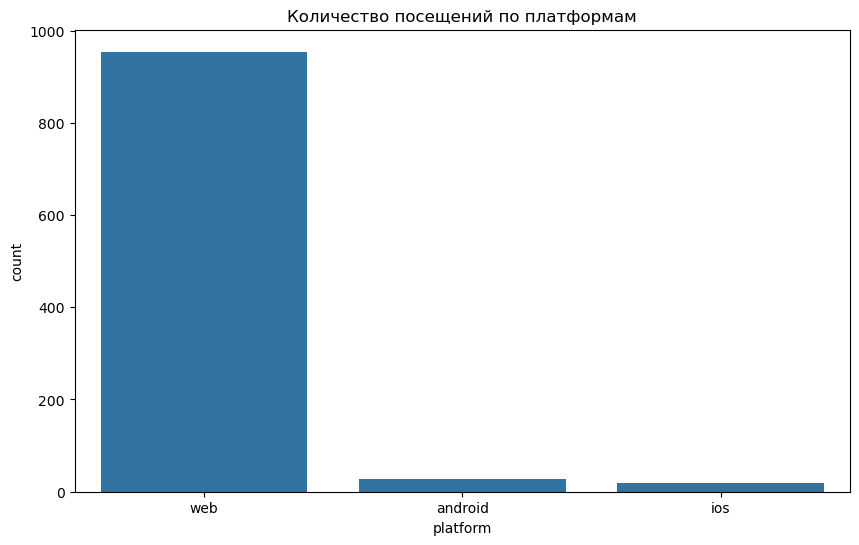

In [25]:
# Пример визуализации количества посещений по платформам
plt.figure(figsize=(10, 6))
sns.countplot(data=visits_df, x='platform')
plt.title('Количество посещений по платформам')
plt.show()

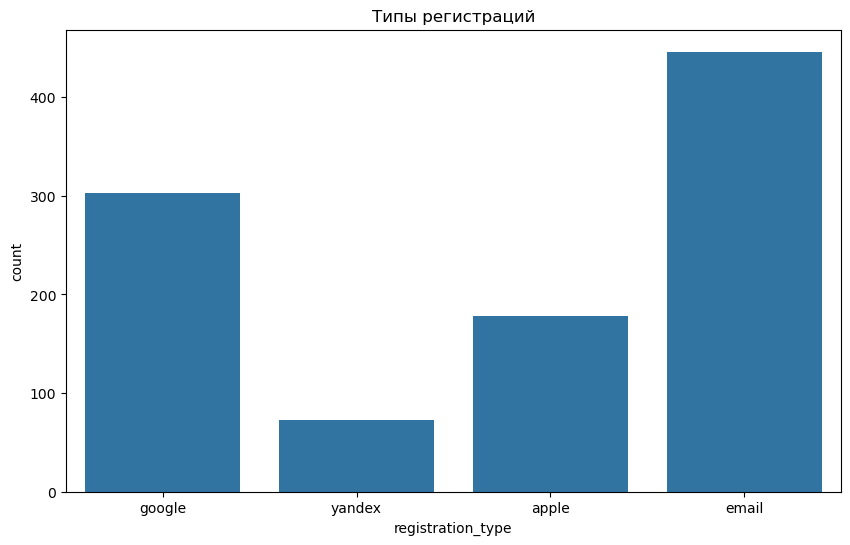

In [27]:
# Пример визуализации регистраций
plt.figure(figsize=(10, 6))
sns.countplot(data=registrations_df, x='registration_type')
plt.title('Типы регистраций')
plt.show()

In [7]:
from pathlib import Path
API_URL='https://data-charts-api.hexlet.app'
DATE_BEGIN="2023-03-01" 
DATE_END="2023-09-01"

date_start = DATE_BEGIN
date_end = DATE_END
visits_resp = requests.get(f'{API_URL}/visits', params={'begin': date_start, 'end': date_end})
reg_resp = requests.get(f'{API_URL}/registrations', params={'begin': date_start, 'end': date_end})
visits_df = pd.DataFrame(visits_resp.json())
registrations_df = pd.DataFrame(reg_resp.json())

In [8]:
# Фильтрация визитов, исключая ботов
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot', case=False)]

In [9]:
# Преобразование столбца date в тип datetime
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime'])

In [10]:
visits_df['date_group'] = visits_df['datetime'].dt.date

In [11]:
registrations_df['date_group'] = registrations_df['datetime'].dt.date

In [12]:
# Группировка данных визитов по дате и платформе
visits_grouped = visits_df.groupby(['date_group', 'platform']).agg(visits=('visit_id', 'nunique')).reset_index()


In [13]:
# Группировка данных регистраций по дате и платформе
registrations_grouped = registrations_df.groupby(['date_group', 'platform']).agg(registrations=('user_id', 'nunique')).reset_index()

In [14]:
# Объединяем датафреймы по дате и платформе
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'])

In [15]:
# Рассчитываем конверсию
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100

In [25]:
# Сохранение итогового датафрейма в формате JSON
merged_df.to_json('conversion.json')

In [27]:
print(merged_df)

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75             61   81.333333
1    2023-03-01      ios      22             18   81.818182
2    2023-03-01      web     815              8    0.981595
3    2023-03-02  android      67             59   88.059701
4    2023-03-02      ios      31             24   77.419355
..          ...      ...     ...            ...         ...
547  2023-08-30      ios      66             40   60.606061
548  2023-08-30      web    1338             34    2.541106
549  2023-08-31  android      57             42   73.684211
550  2023-08-31      ios      50             36   72.000000
551  2023-08-31      web     721             46    6.380028

[552 rows x 5 columns]


In [29]:
# Добавим данные по рекламным компаниям
data = r"C:\Users\user\ads.csv"
ads_df = pd.read_csv(data, encoding = 'windows-1251')

In [31]:
# Преобразуем строку в формат datetime
ads_df['date'] = pd.to_datetime(ads_df['date'])

# Изменяем название колонки
ads_df['date_group'] = ads_df['date'].dt.date

In [33]:
# Агрегируем зараты на рекламу и кампании по датам в соответствии с требованиями
ads_aggregated = ads_df.groupby(['date_group']).agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()

In [35]:
# Объединим таблицы
result_df = pd.merge(merged_df, ads_aggregated, on='date_group', how='left')

In [37]:
# Заполним пустые значения 0 для cost и none для utm_campaign
result_df['cost'].fillna(0)
result_df['utm_campaign'].fillna('none')
# Сортируем по дате
result_df.sort_values(by='date_group', inplace=True)
print(result_df)

     date_group platform  visits  registrations  conversion   cost  \
0    2023-03-01  android      75             61   81.333333  212.0   
1    2023-03-01      ios      22             18   81.818182  212.0   
2    2023-03-01      web     815              8    0.981595  212.0   
3    2023-03-02  android      67             59   88.059701  252.0   
4    2023-03-02      ios      31             24   77.419355  252.0   
..          ...      ...     ...            ...         ...    ...   
546  2023-08-30  android      35             27   77.142857  109.0   
548  2023-08-30      web    1338             34    2.541106  109.0   
550  2023-08-31      ios      50             36   72.000000  215.0   
549  2023-08-31  android      57             42   73.684211  215.0   
551  2023-08-31      web     721             46    6.380028  215.0   

                   utm_campaign  
0    advanced_algorithms_series  
1    advanced_algorithms_series  
2    advanced_algorithms_series  
3    advanced_algorithm

In [37]:
# Сохраняем результат в JSON
result_df.to_json('ads.json')

In [39]:
# Визуализация расчетов
filtered_df = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-04-30')]

In [41]:
# Путь к папке, куда нужно сохранить график
save_folder = './charts'

# Проверяем существование папки, если её нет - создаем
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

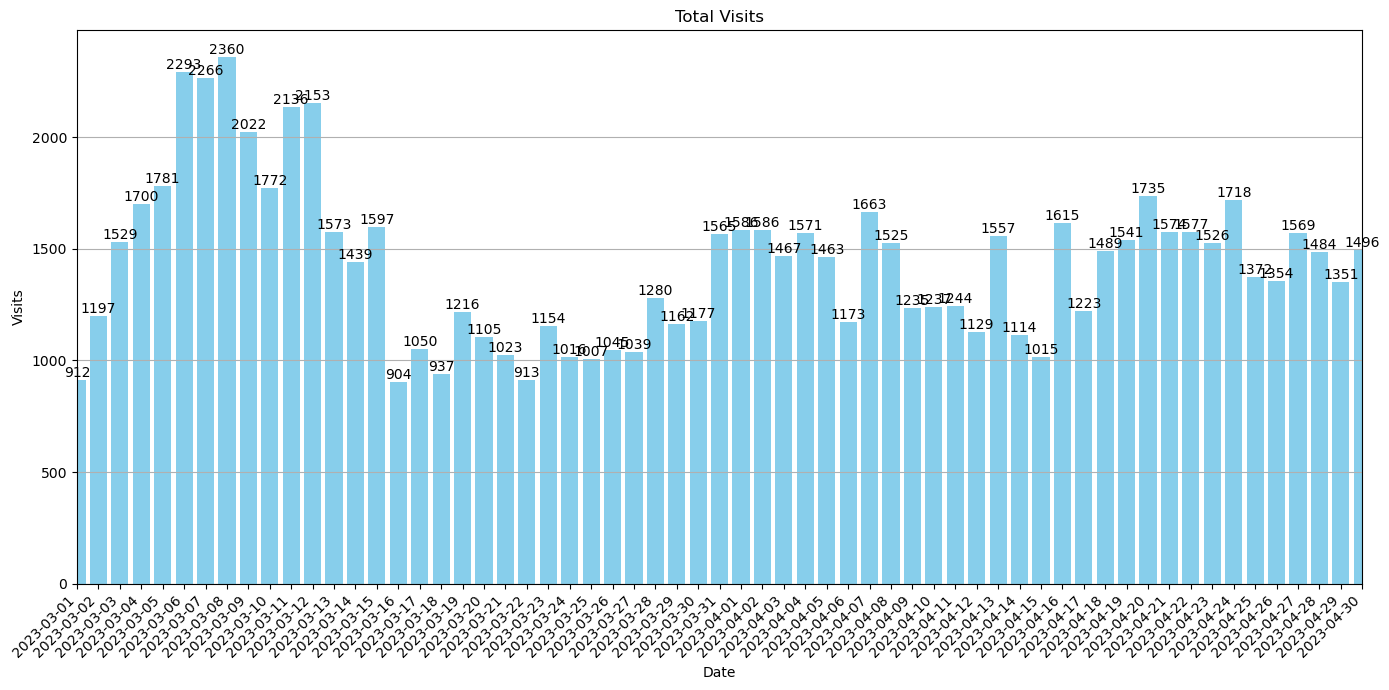

In [43]:
# График Итоговые визиты
grouped_data = filtered_df.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(grouped_data['date_group'], grouped_data['visits'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.title('Total Visits')
plt.xticks(grouped_data['date_group'], rotation=45, ha='right')
plt.grid(axis='y')

plt.xlim(min(grouped_data['date_group']), max(grouped_data['date_group']))


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Total Visits.png'))
plt.show()

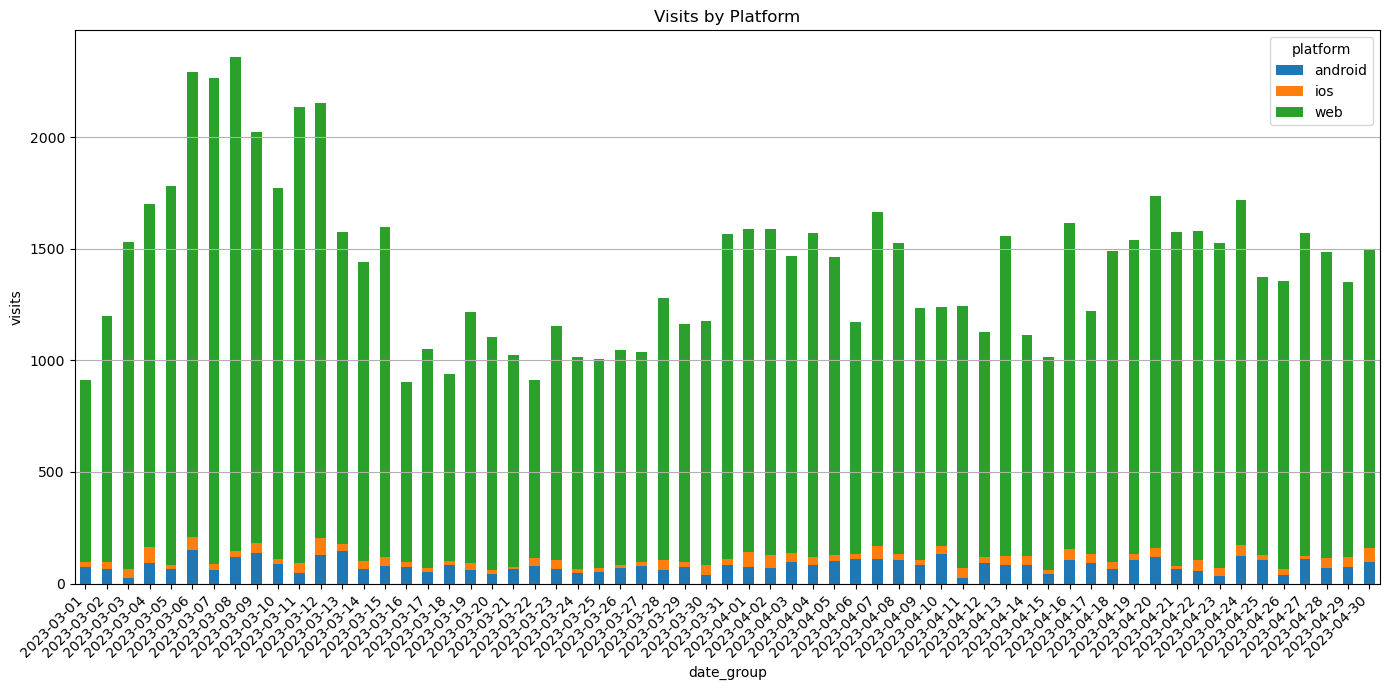

In [44]:
# График Итоговые визиты с разбивкой по платформам
pivot_df = filtered_df.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('visits')
ax.set_title('Visits by Platform')
plt.xticks(filtered_df['date_group'], rotation=45, ha='right')
ax.set_xticks(range(len(pivot_df.index)))
ax.set_xlim(-0.5, len(pivot_df.index)-0.5)

ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Visits_by_platform.png'))
plt.show()

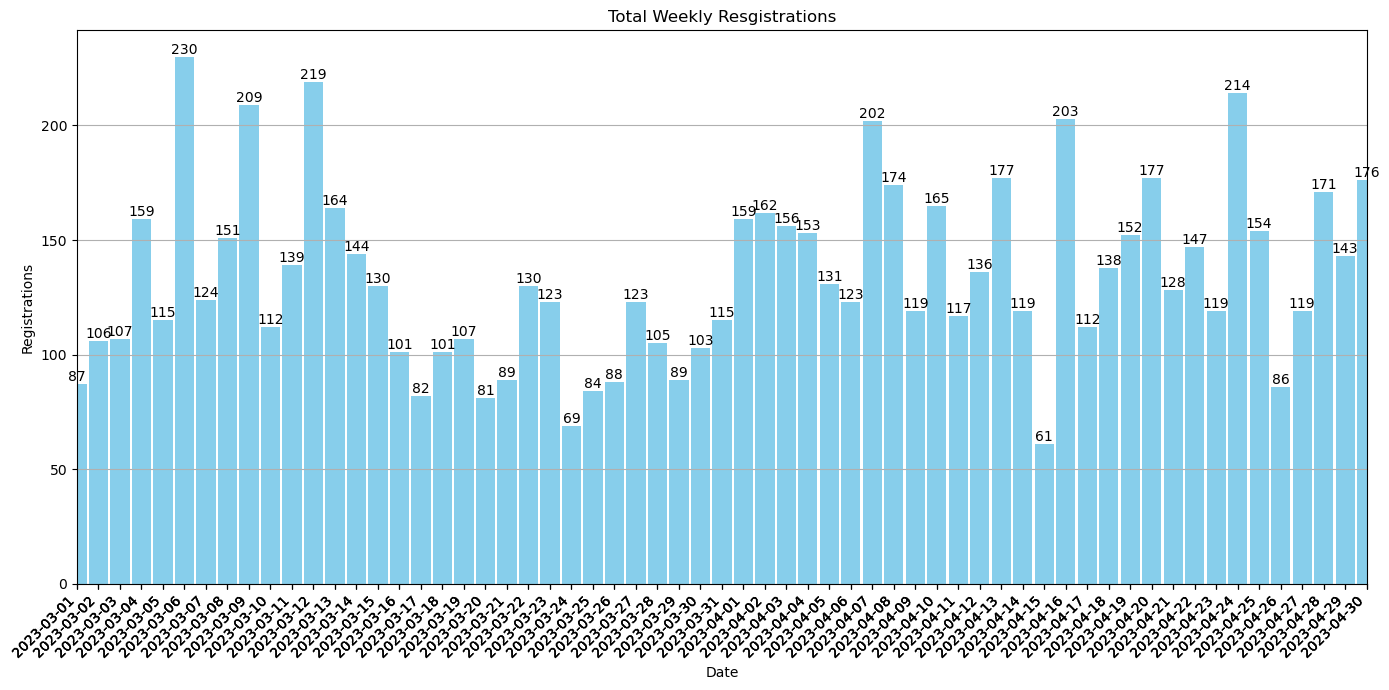

In [46]:
# График Итоговые регистрации
filtered_df_registrations = filtered_df.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(filtered_df_registrations['date_group'], filtered_df_registrations['registrations'], color='skyblue', width=0.9)
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.title('Total Weekly Resgistrations')
plt.xticks(filtered_df['date_group'], rotation=45, ha='right')
plt.grid(axis='y')

plt.xlim(min(grouped_data['date_group']), max(grouped_data['date_group']))

# Добавляем подписи к столбикам по количеству регистраций
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Total Weekly Resgistrations'))
plt.show()

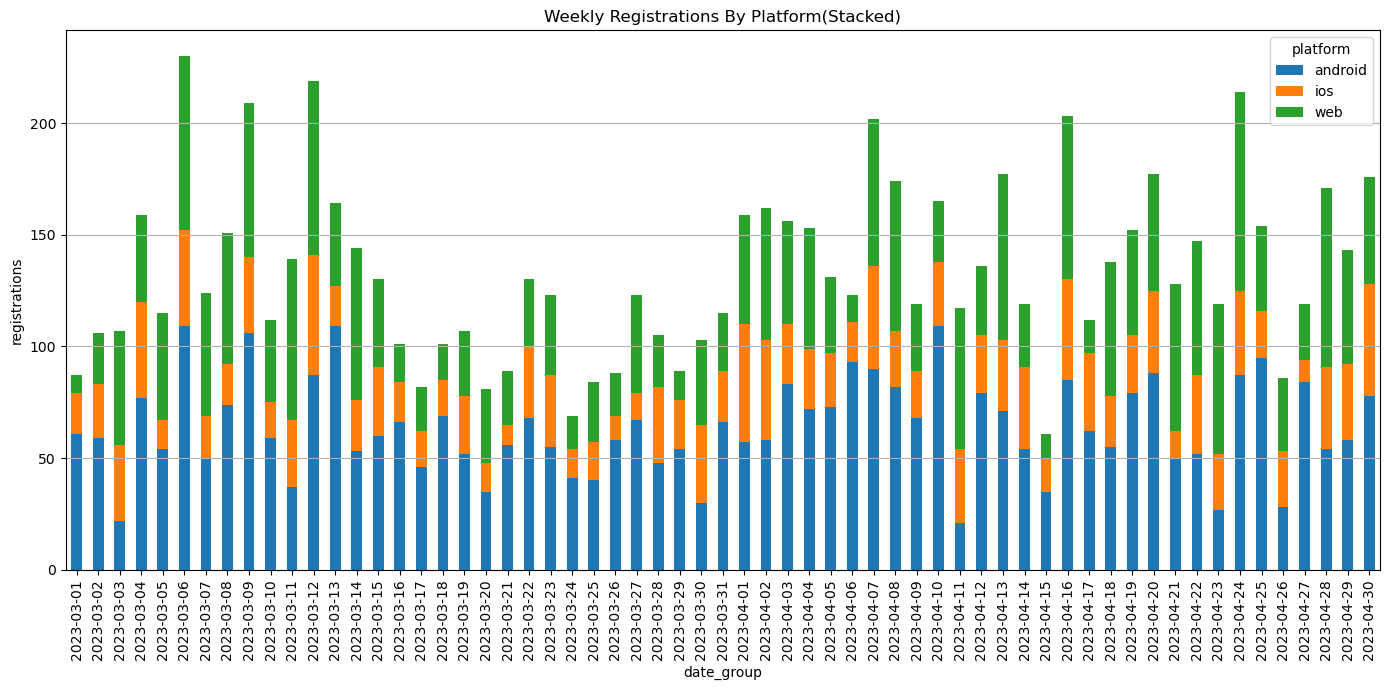

In [48]:
# График Итоговые регистрации с разбивкой по платформе
filtered_df = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-04-30')]

# Преобразуем данные так, чтобы получить сумму посещений для каждой платформы в каждую дату
pivot_df = filtered_df.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('registrations')
ax.set_title('Weekly Registrations By Platform(Stacked)')
ax.set_xticks(range(len(pivot_df.index)))

# Устанавливаем пределы оси x, чтобы убрать пустое место перед первым столбцом и после последнего
ax.set_xlim(-0.5, len(pivot_df.index)-0.5)

ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Weekly Registrations By Platform'))
plt.show()

In [50]:
# График Итоговые конверсии 
# Преобразование столбца даты в формат datetime
result_df['date_group'] = pd.to_datetime(result_df['date_group'])

# Извлечение года и месяца и добавление их в отдельные столбцы
result_df['year_month'] = result_df['date_group'].dt.to_period('M')

# Группировка данных по годам и месяцам и расчет средней конверсии за месяц
monthly_avg_conversion = result_df.groupby('year_month')['conversion'].mean().reset_index()

# Преобразование конверсии в проценты
monthly_avg_conversion['conversion'] = monthly_avg_conversion['conversion']

print(monthly_avg_conversion)

  year_month  conversion
0    2023-03   53.410545
1    2023-04   55.052454
2    2023-05   54.660152
3    2023-06   51.646001
4    2023-07   45.306103
5    2023-08   51.301586


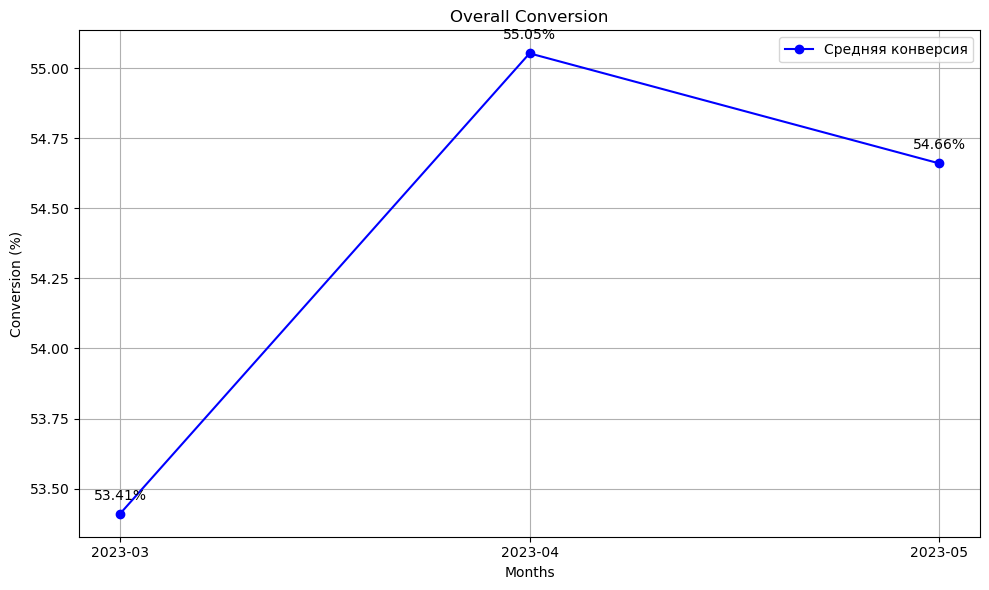

In [52]:
monthly_avg_conversion['year_month'] = monthly_avg_conversion['year_month'].astype(str)
filtered_data = monthly_avg_conversion[(monthly_avg_conversion['year_month'] >= '2023-03') & (monthly_avg_conversion['year_month'] <= '2023-05')]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data['year_month'], filtered_data['conversion'], marker='o', linestyle='-', color='b', label='Средняя конверсия')

for i, txt in enumerate(filtered_data['conversion']):
    plt.annotate(f'{txt:.2f}%', (filtered_data['year_month'].iloc[i], filtered_data['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Months')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.grid(True) 
plt.legend() 

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Overall Conversion'))
plt.show()

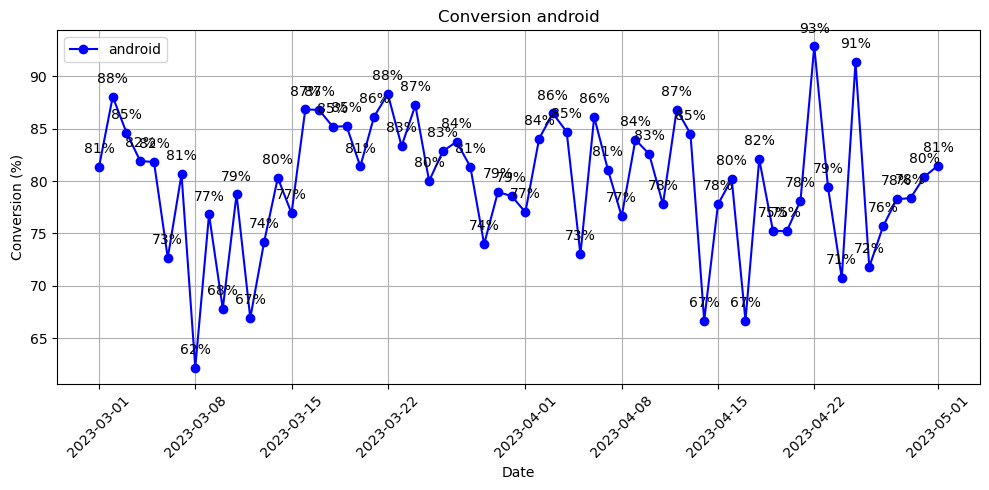

In [54]:
# Конверсия по каждой платформе
filtered_df_conversion = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-05-01')]

# Отфильтруем 3 датасета по каждой из платформ
android_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'android']
android_df.loc[:, 'conversion'] = android_df['conversion']

ios_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'ios']
ios_df.loc[:, 'conversion'] = ios_df['conversion']

web_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'web']
web_df.loc[:, 'conversion'] = web_df['conversion']
plt.figure(figsize=(10, 5))
plt.plot(android_df['date_group'], android_df['conversion'], marker='o', linestyle='-', color='blue', label='android')

for i, txt in enumerate(android_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (android_df['date_group'].iloc[i], android_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Conversion android')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Conversion android'))
plt.show()

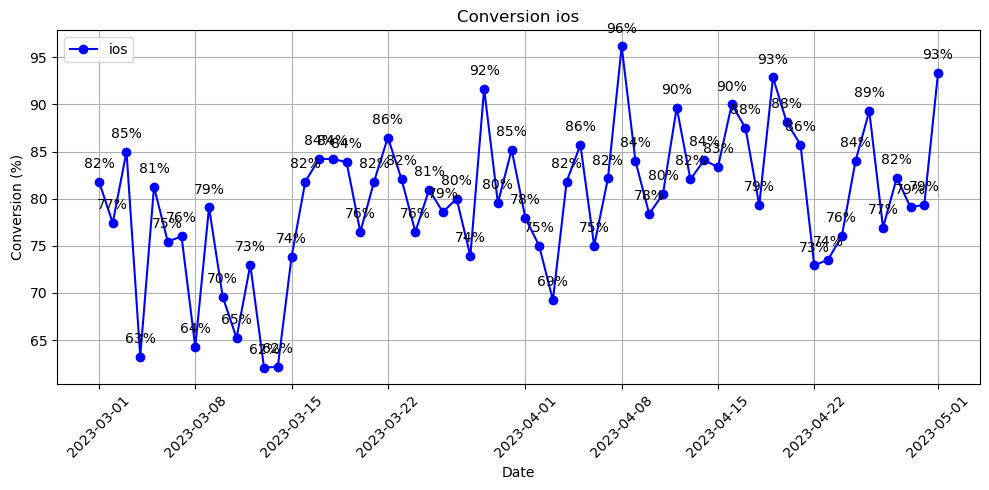

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(ios_df['date_group'], ios_df['conversion'], marker='o', linestyle='-', color='blue', label='ios')

for i, txt in enumerate(ios_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (ios_df['date_group'].iloc[i], ios_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion ios')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Conversion ios'))
plt.show()

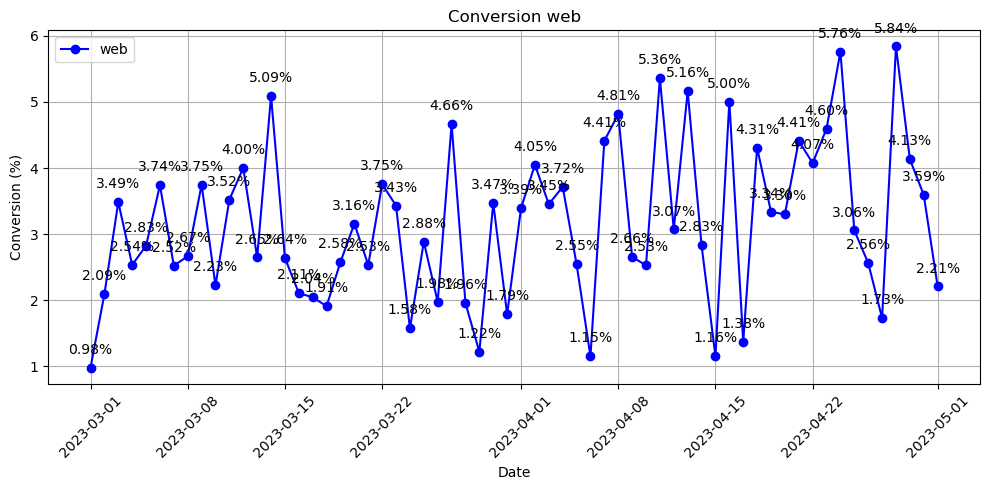

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(web_df['date_group'], web_df['conversion'], marker='o', linestyle='-', color='blue', label='web')

for i, txt in enumerate(web_df['conversion']):
    plt.annotate(f'{txt:.2f}%', (web_df['date_group'].iloc[i], web_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion web')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Conversion web'))
plt.show()

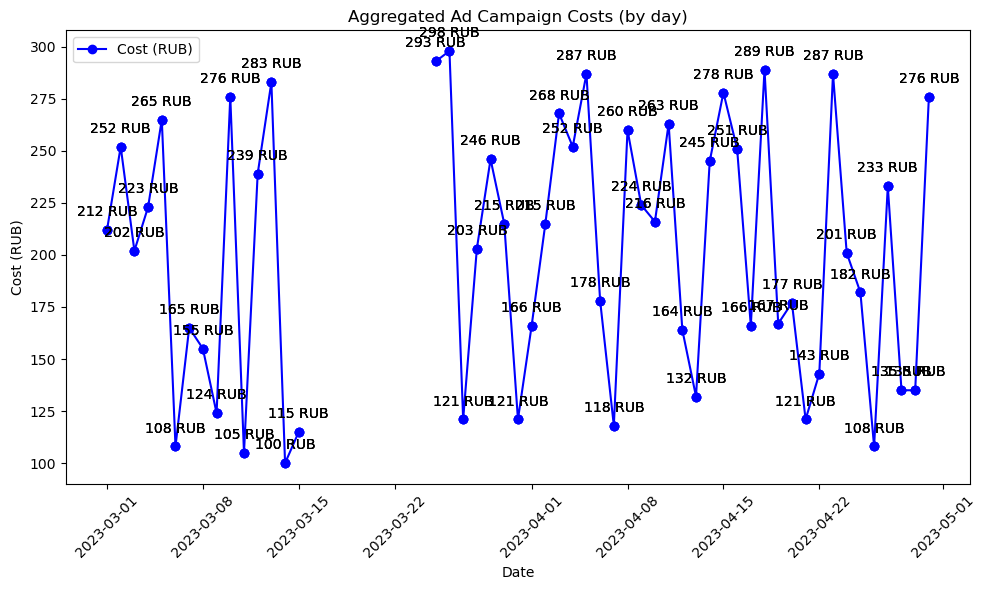

In [74]:
# График стоимости реклам
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['date_group'], filtered_df['cost'], marker='o', linestyle='-', label='Cost (RUB)', color='blue')

for i, txt in enumerate(filtered_df['cost']):
    plt.annotate(f'{txt:.0f} RUB', (filtered_df['date_group'].iloc[i], filtered_df['cost'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.xticks(rotation=45)
plt.legend()  
plt.tight_layout()  
plt.savefig(os.path.join(save_folder, 'Aggregated Ad Campaign Costs (by day)'))
plt.show()

In [49]:
campaign_periods = ads_df.groupby(['utm_campaign']).agg(start = ('date_group', 'min'), end = ('date_group', 'max')).reset_index()
campaign_periods

,utm_campaign,start,end
0,advanced_algorithms_series,2023-03-01,2023-03-15
1,intro_to_python_course,2023-08-06,2023-09-17
2,ui_ux_design_drive,2023-05-19,2023-06-09
3,virtual_reality_workshop,2023-03-25,2023-05-06
4,women_in_tech_symposium,2023-06-21,2023-07-26


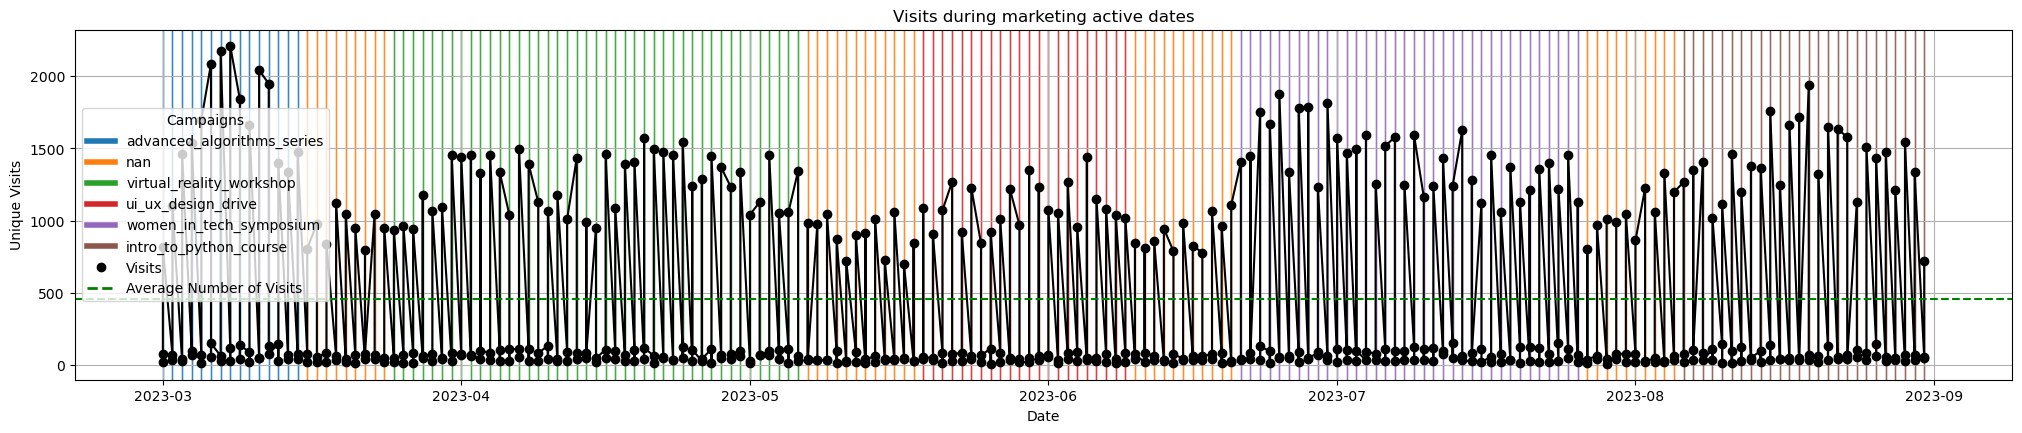

In [47]:
plt.figure(figsize=(25, 10))

# Цвета для рекламных кампаний
campaign_colors = dict(zip(result_df['utm_campaign'].unique(), plt.cm.tab10.colors[:len(result_df['utm_campaign'].unique())]))

plt.subplot(2, 1, 1)

# График визитов
plt.plot(result_df['date_group'], result_df['visits'], marker='o', color='black', label='Visits')
plt.axhline(y=np.nanmean(result_df['visits']), linestyle='dashed', color='green', label='Average Number of Visits')

# Добавление областей для рекламных кампаний
for _, row in result_df.iterrows():
    plt.axvspan(row['date_group'], row['date_group'], color=campaign_colors[row['utm_campaign']], alpha=0.5)

# Добавление легенды для уникальных рекламных кампаний
handles = [plt.Line2D([0], [0], color=campaign_colors[campaign], lw=4, label=campaign) for campaign in campaign_colors]
handles.append(plt.Line2D([0], [0], color='black', marker='o', lw=0, label='Visits'))
handles.append(plt.Line2D([0], [0], linestyle='dashed', color='green', lw=2, label='Average Number of Visits'))

plt.legend(handles=handles, title='Campaigns')

plt.title('Visits during marketing active dates')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.grid(True)

plt.savefig(os.path.join(save_folder, 'Visits during marketing active dates.png'))
plt.show()

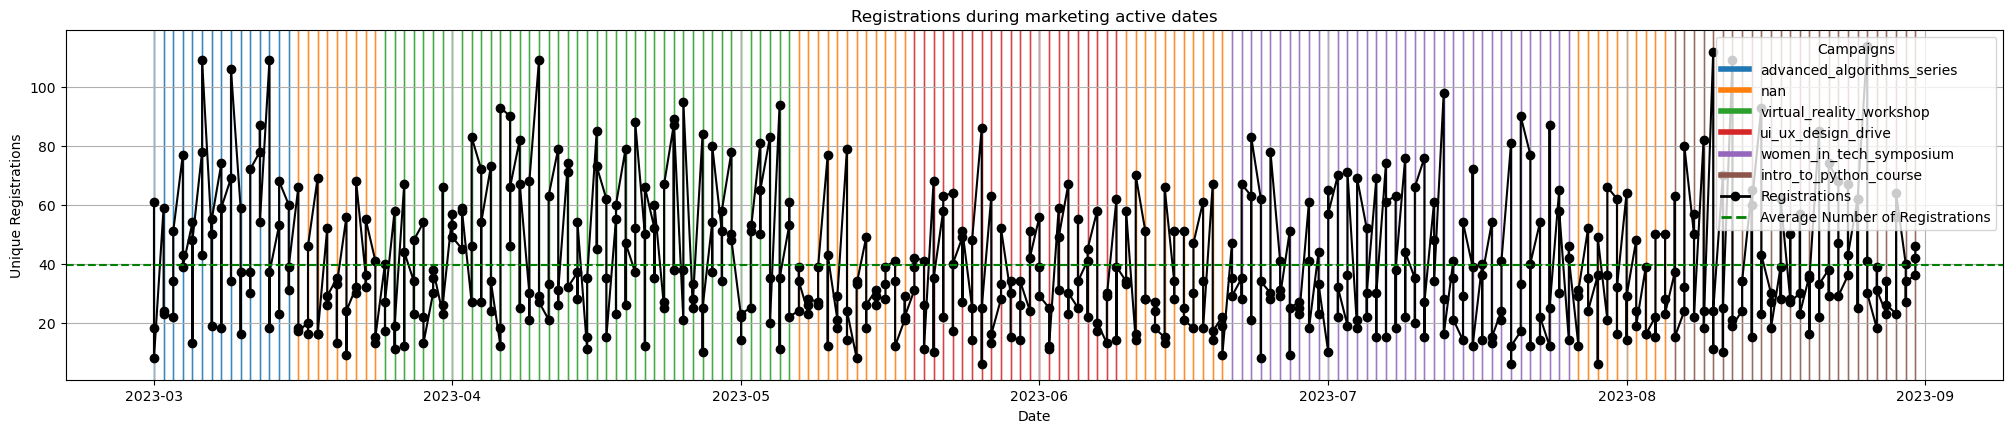

In [49]:
plt.figure(figsize=(25, 10))

# Цвета для рекламных кампаний
campaign_colors = dict(zip(result_df['utm_campaign'].unique(), plt.cm.tab10.colors[:len(result_df['utm_campaign'].unique())]))

plt.subplot(2, 1, 2)  # Изменил на subplot(2, 1, 2) для второго графика

# График регистраций
plt.plot(result_df['date_group'], result_df['registrations'], marker='o', color='black', label='Registrations')
plt.axhline(y=np.nanmean(result_df['registrations']), linestyle='dashed', color='green', label='Average Number of Registrations')

# Добавление областей для рекламных кампаний
for _, row in result_df.iterrows():
    plt.axvspan(row['date_group'], row['date_group'], color=campaign_colors[row['utm_campaign']], alpha=0.5)

# Добавление легенды только для уникальных рекламных кампаний
handles = [plt.Line2D([0], [0], color=campaign_colors[campaign], lw=4) for campaign in campaign_colors]
handles.append(plt.Line2D([0], [0], color='black', lw=2, marker='o', label='Registrations'))
handles.append(plt.Line2D([0], [0], color='green', linestyle='dashed', lw=2, label='Average Number of Registrations'))

plt.legend(handles, list(campaign_colors.keys()) + ['Registrations', 'Average Number of Registrations'], title='Campaigns')

plt.title('Registrations during marketing active dates')
plt.xlabel('Date')
plt.ylabel('Unique Registrations')
plt.grid(True)

plt.savefig(os.path.join(save_folder, 'Registrations during marketing active dates.png'))
plt.show()